# Notes

We provide this notebook for inference and visualizations. 

You can either load images from a dataloader(see Sec. 1) or from a local path(see Sec. 2).

Welcome to join [IDEA](https://idea.edu.cn/en)([中文网址](https://idea.edu.cn/))!

In [2]:
import os, sys
import torch, json
import numpy as np

from main import build_model_main
from util.slconfig import SLConfig
from datasets import build_dataset
from util.visualizer import COCOVisualizer
from util import box_ops

# 0. Initialize and Load Pre-trained Models

In [4]:
model_config_path = "config/DINO/DINO_4scale_swin.py" # change the path of the model config file
model_checkpoint_path = "/home/mark/Desktop/CVPDL/DINO/logs/DINO/R50-MS4/checkpoint0049.pth" # change the path of the model checkpoint
# See our Model Zoo section in README.md for more details about our pretrained models.

In [5]:
args = SLConfig.fromfile(model_config_path) 
args.device = 'cuda' 
model, criterion, postprocessors = build_model_main(args)
checkpoint = torch.load(model_checkpoint_path, map_location='cpu')
model.load_state_dict(checkpoint['model'])
_ = model.eval()

/home/mark/Desktop/CVPDL/DINO/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


use_checkpoint!!!!!!!!!!!!!!!!!!!!!!!!


/home/mark/Desktop/CVPDL/DINO/.venv/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [38]:
# load coco names
with open('util/coco_my_id2name.json') as f:
    id2name = json.load(f)
    id2name = {int(k):v for k,v in id2name.items()}

# 1. Visualize images from a dataloader
## 1.1 Load Datasets

In [7]:
args.dataset_file = 'coco'
args.coco_path = "/home/mark/Desktop/CVPDL/DINO/data" # the path of coco
args.fix_size = False

dataset_val = build_dataset(image_set='val', args=args)   

data_aug_params: {
  "scales": [
    480,
    512,
    544,
    576,
    608,
    640,
    672,
    704,
    736,
    768,
    800
  ],
  "max_size": 1333,
  "scales2_resize": [
    400,
    500,
    600
  ],
  "scales2_crop": [
    384,
    600
  ]
}
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


## 1.2 Get an Example and Visualize it

In [39]:
image, targets = dataset_val[0]

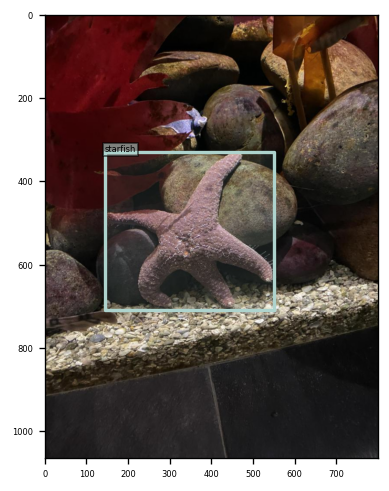

In [40]:
# build gt_dict for vis
box_label = [id2name[int(item)] for item in targets['labels']]
gt_dict = {
    'boxes': targets['boxes'],
    'image_id': targets['image_id'],
    'size': targets['size'],
    'box_label': box_label,
}
vslzr = COCOVisualizer()
vslzr.visualize(image, gt_dict, savedir=None)

## 1.3 Visualize Model Predictions

In [41]:
output = model.cuda()(image[None].cuda())
output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]).cuda())[0]

In [42]:
thershold = 0.3 # set a thershold

scores = output['scores']
labels = output['labels']
boxes = box_ops.box_xyxy_to_cxcywh(output['boxes'])
select_mask = scores > thershold

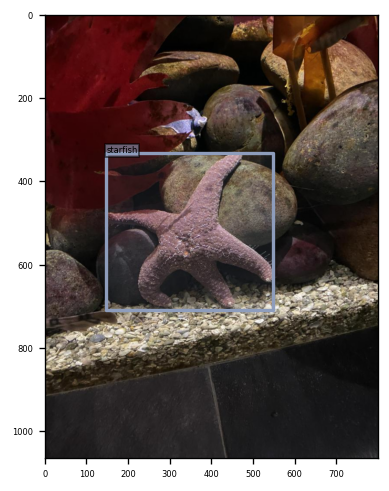

In [43]:
box_label = [id2name[int(item)] for item in labels[select_mask]]
pred_dict = {
    'boxes': boxes[select_mask],
    'size': targets['size'],
    'box_label': box_label
}
vslzr.visualize(image, pred_dict, savedir=None)

# 2. Visualize Custom Images

In [44]:
from PIL import Image
import datasets.transforms as T

In [63]:
image = Image.open("/home/mark/Desktop/CVPDL/DINO/data/val2017/IMG_8535_MOV-1_jpg.rf.1c1aa55d7b35e08b6760c9cc43d427d0.jpg").convert("RGB") # load image

In [64]:
# transform images
transform = T.Compose([
    # T.RandomResize([800], max_size=1333),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
image, _ = transform(image, None)

In [65]:
# predict images
output = model.cuda()(image[None].cuda())
output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]).cuda())[0]

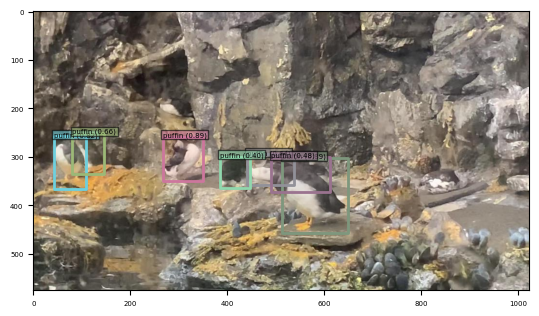

In [66]:
# visualize outputs
thershold = 0.3 # set a thershold

vslzr = COCOVisualizer()

scores = output['scores']
labels = output['labels']
boxes = box_ops.box_xyxy_to_cxcywh(output['boxes'])
select_mask = scores > thershold

box_label = [f"{id2name[int(item)]} ({scores[select_mask][index]:.2f})" for index, item in enumerate(labels[select_mask])]

pred_dict = {
    'boxes': boxes[select_mask],
    'size': torch.Tensor([image.shape[1], image.shape[2]]),
    'box_label': box_label,
}
vslzr.visualize(image, pred_dict, savedir=None, dpi=100)

In [32]:
pred_dict = {
    'boxes': boxes[select_mask],
    'size': torch.Tensor([image.shape[1], image.shape[2]]),
    'box_label': box_label
}

# 3.output correct format of validation prediction

In [50]:
import os
from PIL import Image

def get_images_filenames(dirname):
    # Define the directory containing the images
    directory = dirname

    # Get a list of all files in the directory
    all_files = os.listdir(directory)

    # Filter out only the image files (assuming jpg and png formats for simplicity, but you can expand this)
    image_files = [f for f in all_files if f.endswith('.jpg') or f.endswith('.png')]

    # Read the images into a list and store their file names
    images = []
    filenames = []

    for image_file in image_files:
        # Full path to the image file
        image_path = os.path.join(directory, image_file)
        
        # Open and append the image to the images list
        images.append(Image.open(image_path))
        
        # Append the image filename to the filenames list
        filenames.append(image_file)
    return images, filenames

# Now, 'images' contains the list of images and 'filenames' contains their corresponding file names



In [90]:
images , filenames = get_images_filenames("./data/val2017/")

In [97]:
def predict(src_image):
    image, _ = transform(src_image, None)
    output = model.cuda()(image[None].cuda())
    
    output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]).cuda())[0]
    
    thershold = 0.3 # set a thershold


    scores = output['scores']
    labels = output['labels']
    boxes = output['boxes']
    select_mask = scores > thershold

    # labels = labels[select_mask]
    # scores = scores[select_mask]
    # boxes = boxes[select_mask]

    # Multiply the x-coordinates by x_factor
    boxes[:, 0] *= image.shape[2]
    boxes[:, 2] *= image.shape[2]

    # Multiply the y-coordinates by y_factor
    boxes[:, 1] *= image.shape[1]
    boxes[:, 3] *= image.shape[1]

    pred_dict = {
        "boxes": boxes,
        "labels": labels,
        "scores": scores,
    }
    return pred_dict

In [59]:
predict(images[0])

{'boxes': tensor([[513.1188, 302.0104, 648.5753, 456.2430],
         [266.8711, 258.2256, 349.8282, 349.0269],
         [ 42.0616, 257.2410, 109.0262, 365.5116],
         [ 80.1125, 250.5830, 146.2059, 335.6666],
         [439.9586, 294.9270, 538.1209, 358.1415],
         [491.4007, 300.2103, 611.3401, 373.5240],
         [384.7291, 299.4043, 446.8716, 364.6231]], device='cuda:0'),
 'labels': tensor([4, 4, 4, 4, 4, 4, 4], device='cuda:0'),
 'scores': tensor([0.8899, 0.8896, 0.8174, 0.6566, 0.6424, 0.4834, 0.4014],
        device='cuda:0')}

In [60]:
id2name

{0: 'creatures',
 1: 'fish',
 2: 'jellyfish',
 3: 'penguin',
 4: 'puffin',
 5: 'shark',
 6: 'starfish',
 7: 'stingray'}

In [91]:
result_dict = {}
for i in range(len(images)):
    pred_dict = predict(images[i])
    result_dict[filenames[i]] = pred_dict

In [72]:
result_dict

{'IMG_8535_MOV-1_jpg.rf.1c1aa55d7b35e08b6760c9cc43d427d0.jpg': {'boxes': tensor([[513.1188, 302.0104, 648.5753, 456.2430],
          [266.8711, 258.2256, 349.8282, 349.0269],
          [ 42.0616, 257.2410, 109.0262, 365.5116],
          [ 80.1125, 250.5830, 146.2059, 335.6666],
          [439.9586, 294.9270, 538.1209, 358.1415],
          [491.4007, 300.2103, 611.3401, 373.5240],
          [384.7291, 299.4043, 446.8716, 364.6231]], device='cuda:0'),
  'labels': tensor([4, 4, 4, 4, 4, 4, 4], device='cuda:0'),
  'scores': tensor([0.8899, 0.8896, 0.8174, 0.6566, 0.6424, 0.4834, 0.4014],
         device='cuda:0')},
 'IMG_2288_jpeg_jpg.rf.18da58173e72084ebd73149bc8914ec1.jpg': {'boxes': tensor([[142.3875, 573.5000, 288.1536, 701.1981]], device='cuda:0'),
  'labels': tensor([4], device='cuda:0'),
  'scores': tensor([0.9564], device='cuda:0')},
 'IMG_8348_jpg.rf.f98cd0dfc3a2c7693b77fb490d1405d1.jpg': {'boxes': tensor([[688.6284, 247.0700, 826.9772, 500.3954],
          [536.1906, 525.2035, 68

In [73]:
def tolist(result_dict):
    for key, value in result_dict.items():
        for subkey, tensor_value in value.items():
            if torch.is_tensor(tensor_value):
                value[subkey] = tensor_value.tolist()

In [92]:
tolist(result_dict)
result_dict

{'IMG_8535_MOV-1_jpg.rf.1c1aa55d7b35e08b6760c9cc43d427d0.jpg': {'boxes': [[513.1187744140625,
    302.01043701171875,
    648.5753173828125,
    456.2430419921875],
   [266.8711242675781,
    258.2256164550781,
    349.8282165527344,
    349.02691650390625],
   [42.0616455078125,
    257.2409973144531,
    109.02615356445312,
    365.5115966796875],
   [80.1125259399414, 250.5830078125, 146.20590209960938, 335.66656494140625],
   [439.9586486816406,
    294.927001953125,
    538.1209106445312,
    358.14154052734375],
   [491.4007263183594,
    300.2103271484375,
    611.3401489257812,
    373.5240478515625],
   [384.7291259765625, 299.4042663574219, 446.87158203125, 364.6230773925781],
   [443.437744140625,
    296.11187744140625,
    608.2320556640625,
    368.6969909667969],
   [559.6958618164062,
    299.24029541015625,
    614.8842163085938,
    357.5338134765625],
   [259.8472900390625, 178.50537109375, 317.3255615234375, 227.24217224121094],
   [258.9896545410156,
    178.826065

In [93]:
with open('val_result_all_boxes.json', 'w') as file:
    json.dump(result_dict, file)

# 4. output correct format of test predictions

In [98]:
images, filenames = get_images_filenames("./data/test")

In [99]:
test_result_dict = {}
for i in range(len(images)):
    test_pred_dict = predict(images[i])
    test_result_dict[filenames[i]] = test_pred_dict



In [100]:
tolist(test_result_dict)

In [101]:
with open('test_result_all_boxes.json', 'w') as file:
    json.dump(test_result_dict, file)